# "Gaussian Processes 2 - Application"
> "We look at how to use GP to learn non-linefar partial differential equations"

- toc:true
- branch: master
- badges: true
- comments: true
- author: John J. Molina
- categories: [Gaussian Processes]

We reproduce a recent paper by Raissi and Karniadakis {% cite Raissi2018 %}, in which Gaussian Processes are used to learn partial differential equations from "small" data.
In particular, it is assumed the the general form of the underlying PDE is known, while the model parameters are unspecified.
The proposed method is then used to infer the parameters of the one-dimensional Burgers', Korteweg-de Vries, Kuramoto-Sivishinky, and non-linear Schrödinger equations.
The datasets are taken from earlier work of Rudy et al. {% cite Rudy2017 %}, who have proposed a sparse-regression technique to discover the symbolic form of the governing pde.
The full dataset is available on the [PDE-FIND](https://github.com/snagcliffs/PDE-FIND/tree/master/Datasets) github page (in scipy.io format).

- [Hidden physics models: Machine learning of nonlinear partial differential equations](https://doi.org/10.1016/j.jcp.2017.11.039)<br>
M. Raissi and G. E. Karniadakis, Journal of Computational Physics 357, 125 (2018)

- [Data-driven discovery of partial differential equations](http://advances.sciencemag.org/lookup/doi/10.1126/sciadv.1602614)<br>
S. H. Rudy, S. L. Brunton, J. L. Proctor, and J. N. Kutz, Science Advances 3, e1602614 (2017)

# Preliminaries

In [1]:
#collapse
import jax.numpy as np
import pandas    as pd
import numpy     as onp
import h5py      as h5
import matplotlib    as mpl
import matplotlib.pyplot      as plt
import matplotlib.patheffects as PathEffects
import scipy.io as sio

from scipy import optimize
from jax   import grad, jit, vmap, jacfwd, jacrev
from jax.numpy.lax_numpy import _wraps
from jax.config    import config; config.update("jax_enable_x64", True)
from functools     import partial,reduce
from mpmath        import mp
from numpy         import random
mpl.style.use(['seaborn-poster', 'seaborn-muted'])

#betanalphas' colormap
colors = ["#DCBCBC","#C79999","#B97C7C","#A25050","#8F2727", "#7C0000","#DCBCBC20", "#8F272720","#00000060"]
color  = {i[0]:i[1] for i in zip(['light','light_highlight','mid','mid_highlight','dark','dark_highlight','light_trans','dark_trans','superfine'],colors)}

def addtxt(ax, x, y, txt, fs=8, lw=3, clr='k', bclr='w', rot=0):
    """Add text to figure axis"""
    return ax.text(x, y, txt, color=clr, ha='left', transform=ax.transAxes, rotation=rot, weight='bold',
                   path_effects=[PathEffects.withStroke(linewidth=lw, foreground=bclr)], fontsize=fs)

The following function will load the solutions obtained by Rudy et al., as well as extract the training data (and save it to a separate file for easy recovery).

In [2]:
#collapse-show
eqnames = ['burgers', 'kdv', 'kuramoto_sivishinky', 'nls', 'harmonic_osc']
def parse_data():
    """Function to convert Rudy et al.'s dataset into hdf5 file (save format was not the same for all files...)
    Parse data for equations (kdv, burgers, nls, harmonic_osc, kuramoto_sivishinky)
    """
    with h5.File('../_simulation_data/PDE-FIND/datasets.h5', 'a')as fp:
        for name in eqnames:
            data = sio.loadmat(f'../_simulation_data/PDE-FIND/Datasets/{name}.mat')            
            gp   = fp.require_group(name)
            if name in ['kdv', 'burgers']:
                u = np.real(data['usol']).transpose()
                x = data['x'][0]
                t = data['t'][:,0]
            if name in ['kuramoto_sivishinky']:
                u = data['uu'].transpose()
                x = data['x'][:,0]
                t = data['tt'][0]
            if name in ['nls', 'harmonic_osc']:
                u = data['usol']
                x = data['x'][0]
                t = data['t'][:,0]
            gp.require_dataset(name = 'u', data = u, shape=u.shape, dtype=u.dtype)
            gp.require_dataset(name = 'x', data = x, shape=x.shape, dtype=x.dtype)
            gp.require_dataset(name = 't', data = t, shape=t.shape, dtype=t.dtype)
parse_data()

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Load data from hdf5 file

In [3]:
#collapse-show
def load_data(name):
    with h5.File('../_simulation_data/PDE-FIND/datasets.h5', 'r') as fp:
        u = fp[name]['u'][...]
        x = fp[name]['x'][...]
        t = fp[name]['t'][...]
        return {'x':x, 't':t, 'u':u}
solutions = {name:load_data(name) for name in eqnames}

Below, we plot the spatio-temporal solutions $u(t)$ for each of the four equations (compare with the plots found in Raissi and Karniadakis' paper).

In [65]:
#collapse
def process_solution(ans, params):
    def _plot_line_points(ax, x, u, i,**kargs):
        ax.plot(x, u, **kargs)
        ax.plot(x[i], u[i], color=color['dark'], marker='x', ls='None', mew=2)
        
    fig = plt.figure(figsize=(24,10), constrained_layout=True)
    gs  = fig.add_gridspec(2, 2)
    ax  = fig.add_subplot(gs[0, :])
    bx  = fig.add_subplot(gs[1,0])
    cx  = fig.add_subplot(gs[1,1])

    t,x,u    = ans['t'], ans['x'], ans['u']
    
    #plot full solution + training data slices
    T,X = np.meshgrid(t,x,indexing='ij')
    uu  = u
    if u.dtype == onp.complex:
        uu = onp.abs(uu)
    ax.pcolormesh(T,X,uu, shading='gouraud', cmap=mpl.cm.inferno)
    ax.vlines(t[params['ts']], np.min(x), np.max(x), colors='w')
    addtxt(ax, 0.025, 0.9, params['label'], fs=22, clr='w', bclr='gray')
    
    #plot training data
    ts  = params['ts']
    ns  = params['num']
    random.seed(12345711)
    ids = [np.sort(random.choice(len(x), size=n, replace=False)) for n in ns]
    for i,axis in enumerate([bx, cx]):
        ti,ni,ii = ts[i], ns[i], ids[i]
        addtxt(axis, 0.05, 0.8, f'$t={t[ti]:.2f}$\n${ni}$ training points', fs=22)
        if u.dtype == onp.float:
            _plot_line_points(axis, x, u[ti], ii, color=color['mid'])
        elif u.dtype == onp.complex:
            _plot_line_points(axis, x, np.real(u[ti]), ii, color=color['mid'])
            _plot_line_points(axis, x, np.imag(u[ti]), ii, color=color['mid'], ls='--')
        
    # save training data
    loc=f"../_simulation_data/{params['name']}"
    fmt="%20.16g"
    df = pd.DataFrame({'x':x, 'u0':u[ts[0]], 'u1':u[ts[1]]})
    df.to_csv(f'{loc}_all.dat', sep="\t", float_format=fmt, index=False)
    for j,ii in enumerate(ids):
        df = pd.DataFrame({'x':x[ii], 'u':u[ts[j],ii]})
        df.to_csv(f'{loc}_{j}.dat', sep="\t", float_format=fmt, index=False)
    plt.show()       

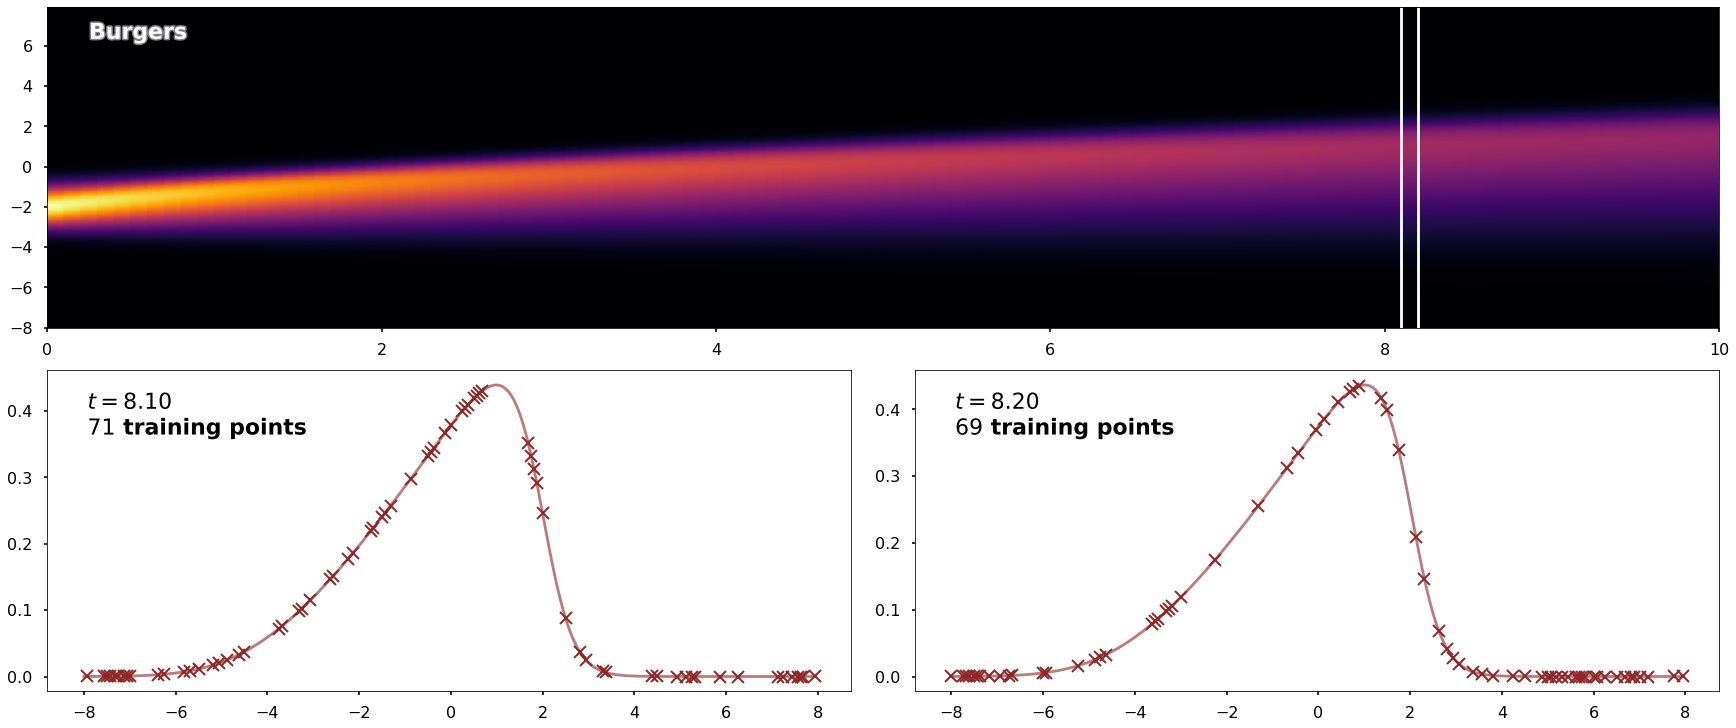

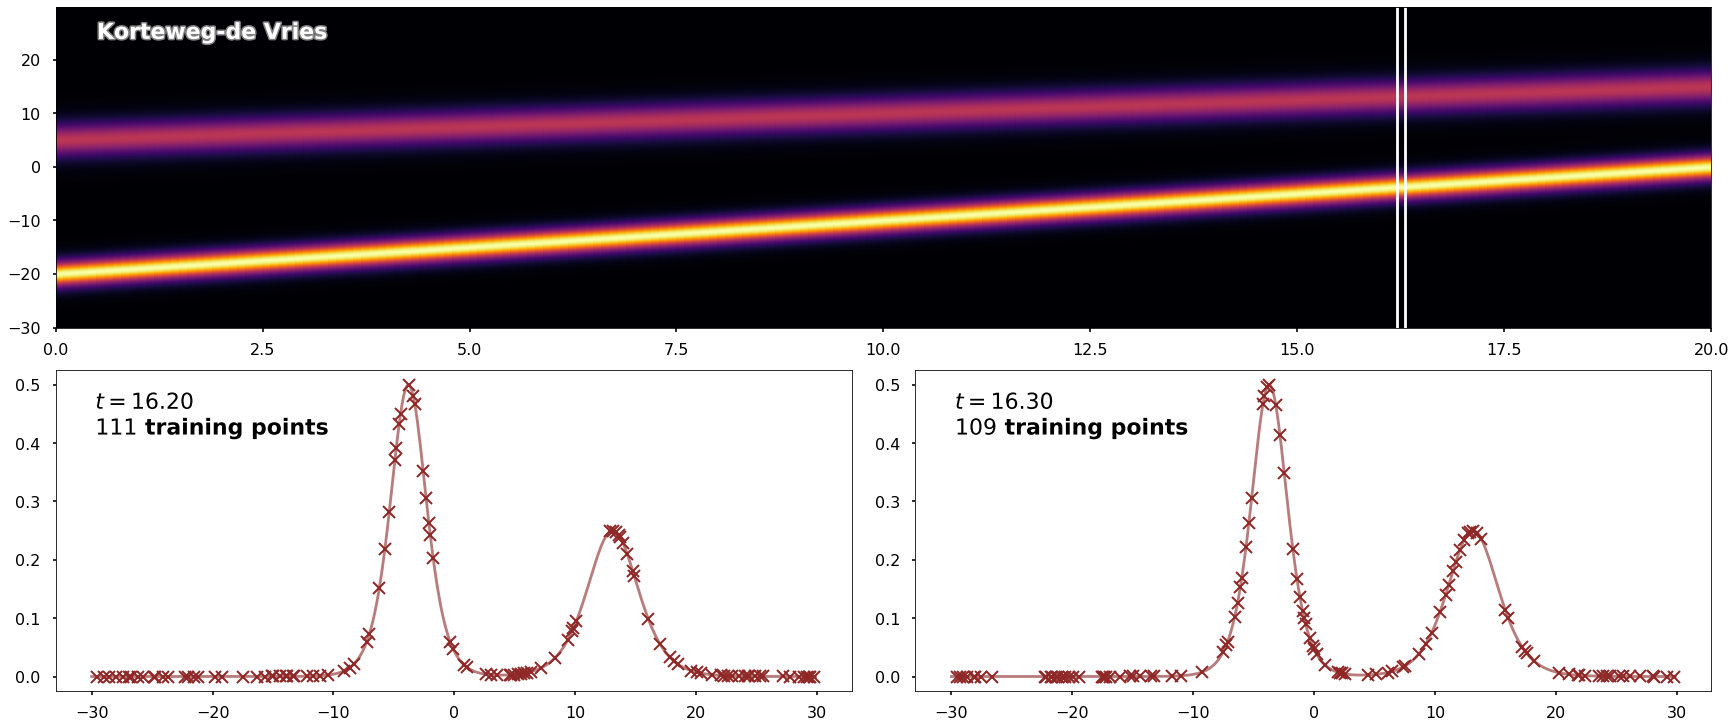

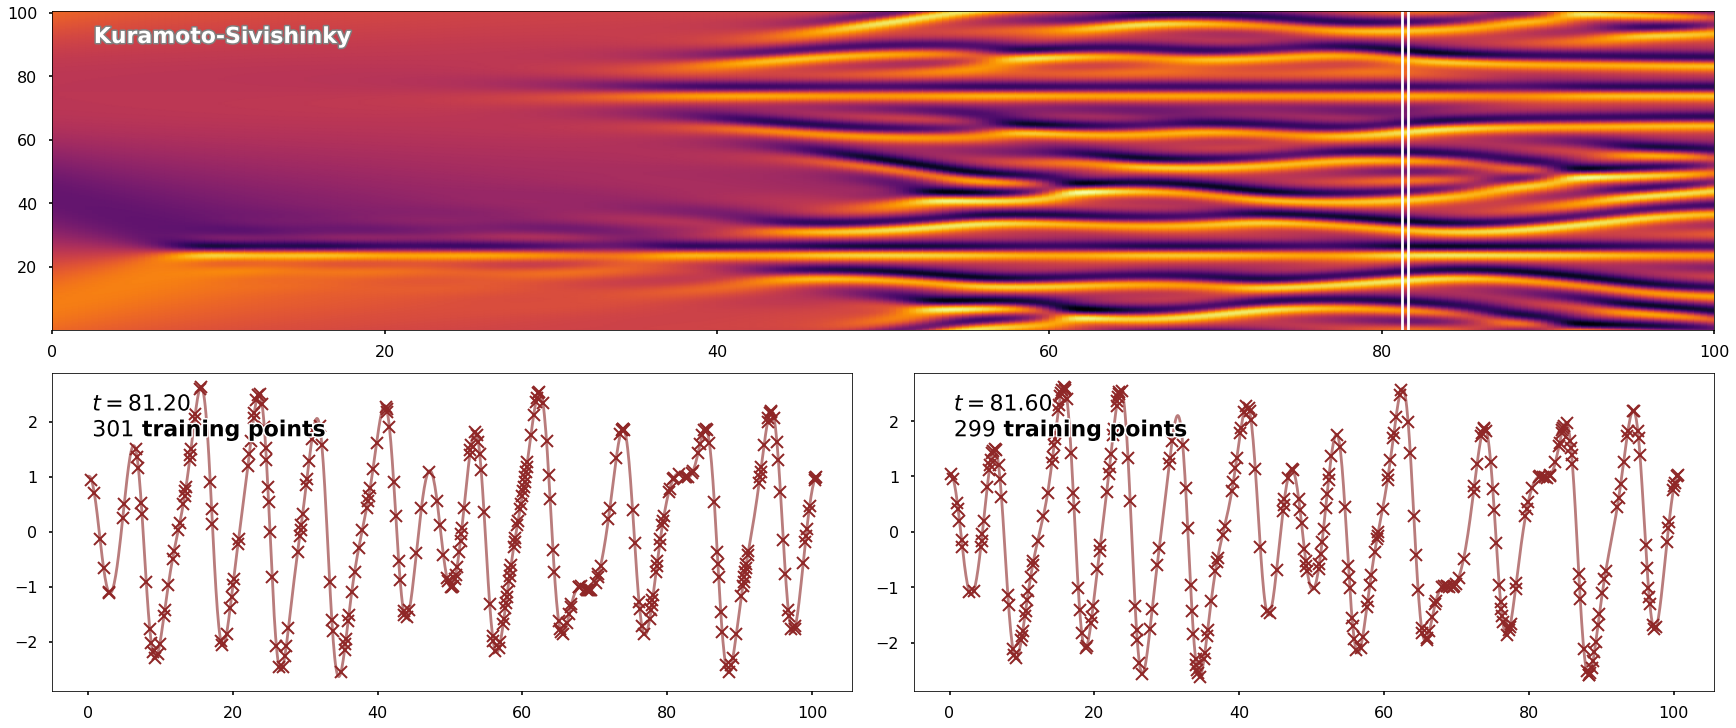

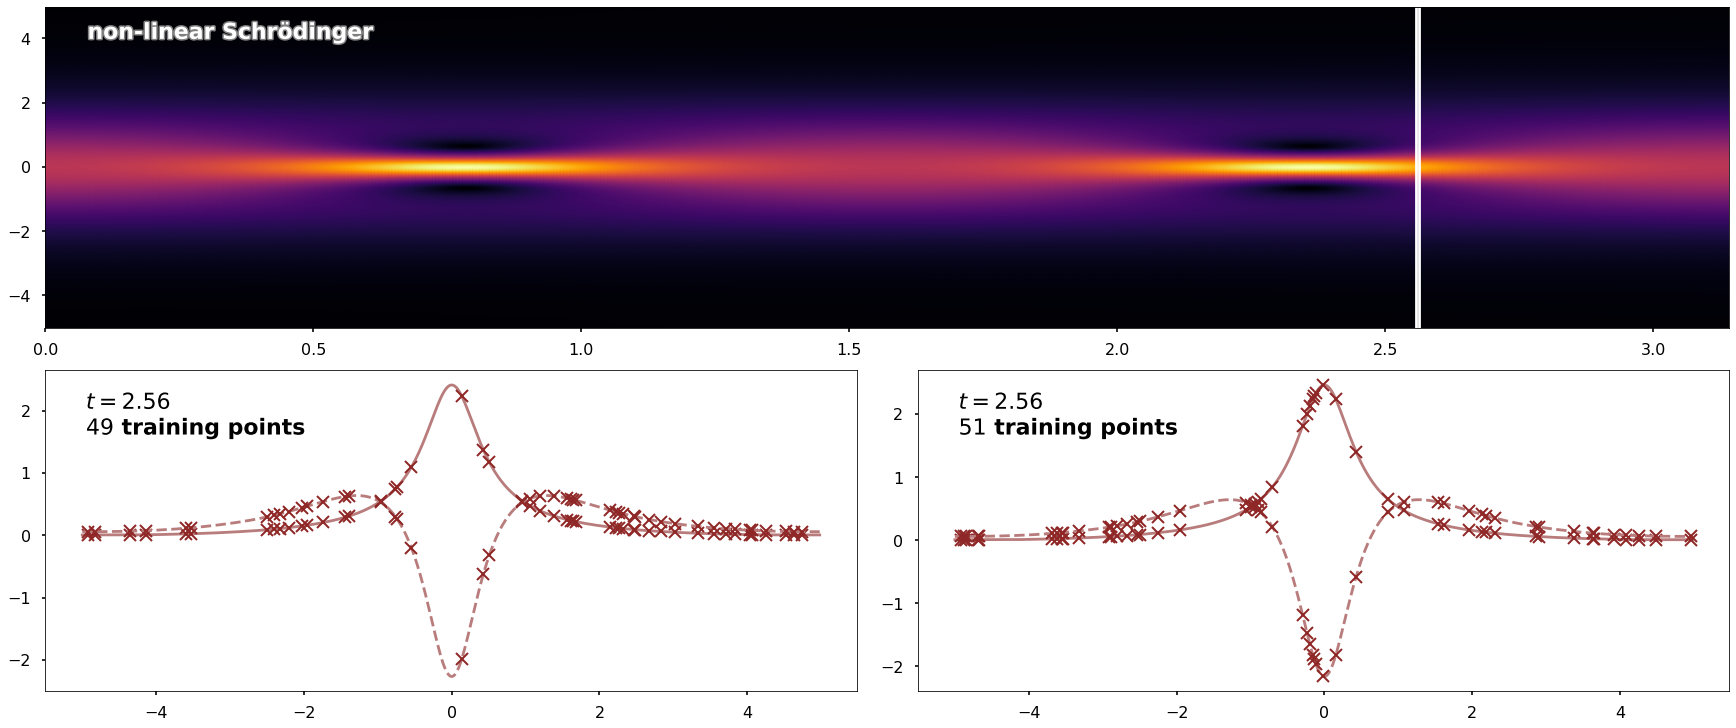

In [66]:
process_solution(solutions['burgers'], {'name':'burgers','label':'Burgers', 'ts':[81,82], 'num':[71,69]})
process_solution(solutions['kdv'], {'name':'kdv','label':'Korteweg-de Vries', 'ts':[162,163], 'num':[111,109]})
process_solution(solutions['kuramoto_sivishinky'], {'name':'ks','label':'Kuramoto-Sivishinky', 'ts':[203,204], 'num':[301,299]})
process_solution(solutions['nls'], {'name':'nls','label':'non-linear Schrödinger', 'ts':[407,408], 'num':[49,51]})

{% bibliography --cited %}